# XGBoost

In [1]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, matthews_corrcoef, make_scorer

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV



def result_model(model,X,Y, f1 = True, mat = True) :
    Y_model =model.predict(X)

    if f1:
        f1_scor = f1_score(Y,Y_model)
        print('Le f1 score vaut',f1_scor)
        
        
    # Matrice de confusion
    if mat:
        cm_model = confusion_matrix(Y, Y_model)
        plt.rcParams['figure.figsize'] = (5, 5)
        sns.heatmap(cm_model, annot = True)
        plt.title(str(model))
        plt.show()
    

## Téléchargement des données

In [2]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [3]:
X = train.drop(columns='Response')
Y = train['Response']

Ensuite, on décompose en bdd train et test puis on scale les données grâce à sklearn.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

Le modèle final sera entrainé sur l'intégralité de la base que nous possédons. Mais actuellement, nous souhaitons mesure le caractère prédictif de nos données et donc pour éviter l'overfitting, nous séparons tout de même nos données.

## Implémentation

In [5]:
xgb0 = xgb.XGBClassifier(use_label_encoder=False)
xgb0.fit(X_train, Y_train)

[10:09:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
result_model(xgb0, X_test, Y_test, mat = False)

Le f1 score vaut 0.39774506733479487


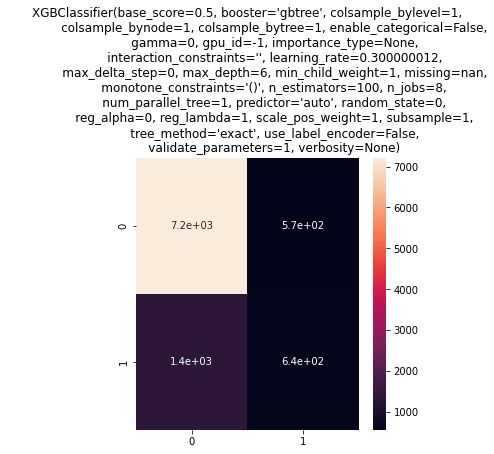

In [7]:
result_model(xgb0, X_test, Y_test, mat = True, f1 = False)

## Tuning

Pour tuner le programme, on s'inspire grandement de [ce site](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h2_9).
Nous utilisons la fonction GridSearchCV de *sklearn*.

In [8]:
from sklearn.model_selection import GridSearchCV  

In [9]:
# Bloc non affiché

#Import libraries:


# import matplotlib.pylab as plt
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4

Si la metrics f1 existait dans la fonction cv d'XGBoost, nous aurions pu l'utiliser de la cross validation pour adapter *n_estimators* au fur et à mesure du tuning. Actuellement, ce n'est pas le cas, nous nous contenterons d'utiliser la même méthode d'entrainement et de test que précédemment. Ceci a pour intérêt de permettre facilement de comparer les résultats.

Voici l'algorithme pour l'exemple : 

In [47]:
def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='error', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    # dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print("\nEstimateur efficient :", cvresult.shape[0])
    print("\nMesures :")
    print("---------")
    print("f1 : ", f1_score(dtrain[target].values, dtrain_predictions))

    return(alg)

### Étape 1 : Initialisation

Dans un premier temps, on récupère les paramètres de bases que l'on va tuner par la suite.

In [58]:
params = xgb0.get_xgb_params()

On modifie quelques paramètres de base au regard des TP réalisés.

In [59]:
params['seed'] = 27 # Pour retrouver les résultats
params['nthread'] = 7 # Utilisation maximale des capacités de la machine utilisée
params["use_label_encoder"] = False # Masquer les warning.

In [62]:
train_train = pd.concat([X_train, Y_train], axis = 1)

target = 'Response'
predictors = [x for x in train.columns if x not in [target]]

In [66]:
param_estimator1 = {
 'n_estimators':[900, 1000, 1100, 1200]
}

In [67]:
gsearch_est1 = GridSearchCV(
    estimator = XGBClassifier(**params),
    param_grid = param_estimator1, scoring='f1', n_jobs=4, cv=5)
 
gsearch_est1.fit(train[predictors],train[target])

In [65]:
gsearch_est1.best_params_, gsearch_est1.best_score_

({'n_estimators': 1000}, 0.40463484708990033)

In [ ]:
params["n_estimators"] = 1000

In [54]:
xgb1 = XGBClassifier(**params)

In [55]:
xgb1.fit(X_train, Y_train)

[10:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=7,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [56]:
result_model(xgb1, X_test, Y_test, mat = False)

Le f1 score vaut 0.41000852999715665


### Étape 2 : max_depth et min_child_weight

Lors du tuning, nous diminuons le nombre d'estimators pour réduire le temps de calcul

In [160]:
params["n_estimators"] = 19

On tune max_depth et min_child_weight

In [161]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6)
}

Nous utilisons l'outil gsearch de *sklearn* pour tester différents paramètres en ayant comme mesure de scoring le F1-Score. Voici l'implémentation qui sera masquée par la suite.

In [162]:
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(**params),
    param_grid = param_test1, scoring='f1', n_jobs=4, cv=5)
 
gsearch1.fit(train[predictors],train[target])

[10:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()', n_estimators=19,
                                     n_jobs=8, nthread=7, num_parallel_tree=1,
                                     predictor='auto', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, subsa

On récupère les paramètres optimaux identifiés.

In [73]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 5}, 0.4024780585914988)

Nous pouvons modifier *min_child_weight* dans les paramètres.

In [74]:
params["max_depth"] = 9
params["min_child_weight"] = 5

Étant à la limite sur les deux paramètres, nous testons avec des paramètres plus forts.

In [75]:
param_test2 = {
'max_depth':[9, 20, 45, 50, 75],
'min_child_weight':[5, 10, 20]
}

gsearch2 = GridSearchCV(
                estimator = XGBClassifier(**params),
                param_grid = param_test2, scoring='f1',n_jobs=4,cv=5)

gsearch2.fit(train[predictors],train[target])

[00:37:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=9,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, subs

In [76]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 50, 'min_child_weight': 5}, 0.41722053132398057)

In [77]:
params["max_depth"] = 50

Nous pouvons essayer d'affiner l'ajustement.

In [51]:
param_test2b = {
    'max_depth':[45, 50, 55],
}

In [52]:
gsearch2b = GridSearchCV(
                estimator = XGBClassifier(**params), 
                param_grid = param_test2b, scoring='f1',n_jobs=4, cv=5)

gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, sub

In [55]:
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 50}, 0.41722053132398057)

On conserve donc max_depth = 50.

### Étape 3 : Gamma

Maintenant, nous répétons le même mécanisme pour le paramètre *Gamma*.

1. Définir les valeurs de Gamma à tester
2. Utiliser GridSearchCV
3. Choisir de conserver, modifier, ou d'affiner encore Gamma.

In [57]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [58]:
gsearch3 = GridSearchCV(estimator = XGBClassifier(**params), 
                        param_grid = param_test3, scoring='f1',n_jobs=4, cv=5)

gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, sub

In [59]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.41722053132398057)

In [78]:
params["gamma"] = 0

Nous ne modifions pas *Gamma* et laissons le paramètre à 0.

Avant de continuer, nous ré-augmentons n_estimators pour voir où est le modèle si nous augmentons le nombre de boosting rounds.


Mesures :
---------
Accuracy :  0.8635658438426445
f1 :  0.6138260869565217


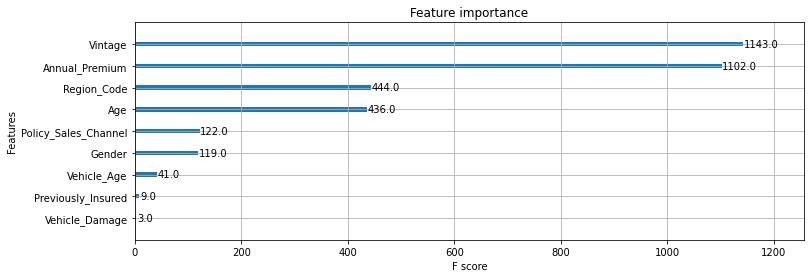

In [52]:
params["n_estimators"] = 1000
xgb2 = XGBClassifier(**params)
modelfit(xgb2, train, predictors)

### Etape 4 : subsample et colsample_bytree

Nous rétablissons *n_estimators* pour la puissance de calcul.

In [53]:
params["n_estimators"] = 140

Génération des paramètres à tester :

In [63]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [64]:
gsearch4 = GridSearchCV(
    estimator = XGBClassifier(**params), 
    param_grid = param_test4, scoring='f1',n_jobs=4, cv=5)
    
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, sub

In [65]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.42095524066535334)

Nous modifions les paramètres identifiés

In [79]:
params["subsample"] = 0.7
params["colsample_bytree"] = 0.9

Nous affinons les tests sur ces paramètres.

In [70]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

In [71]:
gsearch5 = GridSearchCV(
                estimator = XGBClassifier(**params), 
                param_grid = param_test5, scoring='f1',n_jobs=4, cv=5)

gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=50,
                                     min_child_weight=5, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, s

In [73]:
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.42095524066535334)

Cela confirme les valeurs 0.9 et 0.7 trouvées précédemment.

### Étape 5 : reg_alpha

Prochaine étape : optimisation de *reg_alpha*.

In [77]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [78]:
gsearch6 = GridSearchCV(estimator = XGBClassifier(**params), 
                        param_grid = param_test6, scoring='f1',n_jobs=4, cv=5)
                        
gsearch6.fit(train[predictors],train[target])

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0.1,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=50, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_wei

In [80]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.41076480565646045)

On modifie le paramètre.

In [80]:
params["reg_alpha"] = 1e-5

Avant de continuer, nous ré-augmentons n_estimators pour voir où est le modèle si nous augmentons le nombre de boosting rounds.


Mesures :
---------
Accuracy :  0.8651326400516121
f1 :  0.6105048354183302


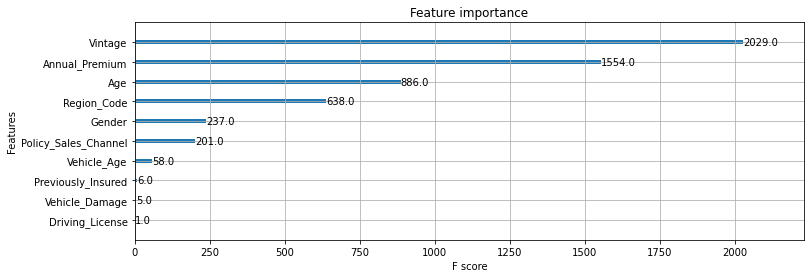

In [56]:
params["n_estimators"] = 1000
xgb3 = XGBClassifier(**params)
modelfit(xgb3, train, predictors)

### Etape 6 : Learning rate

Enfin, nous essayons de diminuer le *learning_rate* et d'augmenter grandement les *n_estimators*.

In [105]:
params["n_estimators"] = 5000
params["learning_rate"] = 0.01


Mesures :
---------
Accuracy :  0.8634275971183238
f1 :  0.5663984394050231


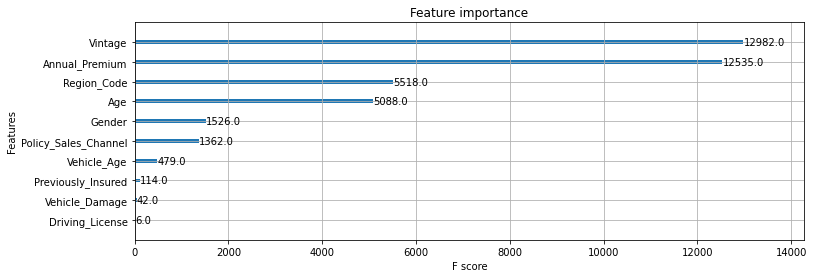

In [106]:
xgb4 = XGBClassifier(**params)
modelfit(xgb4, train, predictors)

In [133]:
xgb4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=50,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=51, n_jobs=8, nthread=7, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=1e-05, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.7, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

Le F1-Score ne s'améliore pas, nous revenons aux anciens paramètres.

In [90]:
params["n_estimators"] = 1000
params["learning_rate"] = 0.1

### Imbalanced


In [124]:
from imblearn.under_sampling import RandomUnderSampler

alpha = 1
rus = RandomUnderSampler(sampling_strategy = alpha)
X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)

In [129]:

import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier(**params)

def model_imb2(alpha,model) :
    rus = RandomUnderSampler(sampling_strategy = alpha)
    X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)
    model.fit(X_rus,Y_rus)
    return model

def f1_scorer(clf,X,Y) :
    Y_clf = clf.predict(X)
    score = f1_score(Y,Y_clf)
    return score


In [130]:
list_model = []
list_alpha =  np.linspace(0.5,1,10)
score_alpha = []

for i in list_alpha :
    a = model_imb2(i,xgb)
    list_model.append(a)
    f1 = f1_scorer(a,X_test , Y_test)
    score_alpha.append(f1)

[08:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:07:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

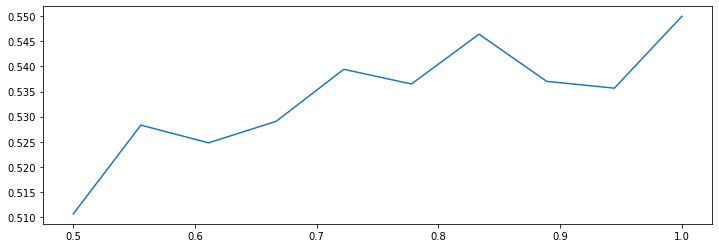

In [132]:
plt.plot(list_alpha, score_alpha)

## Paramètres finaux

Au final, les paramètres obtenus sont :

In [43]:
params

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'n_estimators': 1000,
 'seed': 27,
 'nthread': 7,
 'use_label_encoder': False}

Nous reprendons ces paramètres dans le prochains notebook concernant le modèle final utilisé pour générer les prédictions sur la base test.

## Conclusion

Tuner un modèle XGBoost nécessite énormement de temps de calcul. Dans ce projet, nous avons restreint le nombre de paramètres. Bien sûr, avec davantage de puissance, nous aurions pu calibrer plus précisement les paramètres étudiés et tuner d'autres paramètres non traités dans ce notebook.

<br><br><br><br><br>

## Rappels théoriques

Le Boosting de Gradient est un algorithme d’apprentissage supervisé dont le principe est de combiner les résultats d’un ensemble de modèles moins performants afin de fournir la meilleure prédiction possible.

Un exemple classique est le modèle linéaire défini comme ci-suit  $\hat{y}_i = \sum_j \theta_j x_{ij}$ qui représente une combinaison de plusieurs variables plus ou moins significatives.

En choisissant judicieusement notre $y_i$, nous pouvons à partir de notre jeu de données faire des régressions et de la classification.

Lorque nous entrainons notre modèle, nous cherchons à définir le meilleur paramètre $ \theta  $ qui ajustera nos données $x_i$ et nous permettra d'obtenir les meilleurs prédictions de $y_i$. Pour entrainer notre modèle, nous avons besoin d'une fonction dite d'objectif afin d'estimer si notre modèle est performant ou non. \
Notre fonction dite d'objectif est définie de la manière suivante :
$$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$$

Dans cette expression nous retrouvons deux composants :\
Le premier $L$, la fonction d'entrainement, le second $\Omega$ qui est le terme de régulation.\
$L$ va donc estimer la performance prédicitive de notre modèle.\
Un choix classique pour $L$ est la mesure la mean squared error (MSE) donnée par : $$ L(\theta) = \sum_i (y_i-\hat{y}_i)^2  $$

Il existe également la fonction de logistic loss qui peut également être utilisée comme fonction d'entrainement: 

$$ L(\theta) = \sum_i[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})]  $$

Le terme de régulation est assez souvent oublié; c'est pourtant lui qui contrôle la compléxité du modèle et nous empêche d'entrainer notre modèle en overfittant.

![Texte alternatif](https://drive.google.com/uc?id=1ks-oizjnu3-rThY-gecix6BpKFWy__FM)

La présentation de la méthode XGBoost ne peut se faire sans introduire la notion d'arbre de décision.

![Texte alternatif](https://drive.google.com/uc?id=1R7HcQg2z2cJ14GSCOL45VsWfHGT0-f37)

Dans notre exemple, il s'agit d'un modèle qui doit classifier suivant deux variables l'âge ainsi que l'utilisation quotidienne d'un ordinateur. Le modèle alloue a chaque échantillon un score de prédiction.

Mathématiquement, le score peut s'écrire sous la forme :

$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$

où $K$ est le nombre d'arbres, $f$ une fonction dans $\mathcal{F}$ et $\mathcal{F}$ est l'ensemble des arbres de classification et de regression.\
L'objectif est d'optimiser la fonction suivante : 

$$ \text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

Mainteant que nous avons introduit le modèle, nous pouvons passer à l'entrainement de ce dernier. Nous allons définir une fonction d'objectif que nous optimiserons.\
Notre fonction d'objectif est défini comme étant :

$$ \text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) $$

Nous devons chercher premièrement les paramètres de notre arbre. Les structures de nos arbres sont contenus dans les fonctions $f_i$. Il s'avère complexe d'optimiser la structure d'un arbre, il ne s'agit pas simplement de problèmes de gradients.\
Ici nous fixons ce que nous avons à apprendre puis nous ajoutons un arbre à la fois. Notre valeur de prédiction avec un pas de $t$ pour la fonction $\hat{y}_i^{(t)}$ s'écrit : 


$$

\begin{split}

\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)

\end{split}

$$

La question qui se pose alors est : quel arbre ajouté après un pas ?. La réponse est l'arbre qui optimise le mieux notre prédiction.


$$

\begin{split}

\text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + \mathrm{constant}

\end{split}

$$

Lorsque la mean squared error (MSE) est utilisée, notre fonction d'objectif devient 

$$

\begin{split}

\text{obj}^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + \mathrm{constant}

\end{split}

$$

L'utilisation de la MSE est assez courante avec un résidu et un terme quadratique.
La fonction d'objectif devient alors : 

$$ \text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant} $$
 
 où $g_i$ et $h_i$ sont :

$$

 \begin{split}

 g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})

\end{split}

$$
Après supression de toutes les constantes, nous obtenons : 

$$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$

Cette expression devient notre objectif pour les nouveaux arbres. La valeur de notre prédiction ne va alors dépendre que de $g_i$ et $h_i$. Il est possible d'optimiser chaque loss function en utilisant simplement les mêmes entrées $g_i$et $h_i$.

Maintenant que le terme d'entrainement est déterminé, il est nécessaire de définir le terme de régulation qui intervient dans la gestion de la complexité du modèle.\
La complexité de notre arbre est représentée par $\Omega(f)$ qui est defini par la fonction $f(x)$ :

$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} .$$

où $w$ est le  vecteur de score, $q$ est la fonction qui alloue la bonne feuille et $T$ le nombre de feuilles.
Pour la methode XGBoost, nous pouvons définir la complexité du modèle comme étant :

$$ \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2 $$

Il existe d'autres façons de définir la complexité du modèle; cependant celle énoncée précédemment s'avère être fonctionnelle et efficace. L'aspect de régulation est souvent sous-estimé voir même ingoré. En définissant la complexité de façon formelle, nous avons un meilleur aperçu de notre modèle et de son niveau de performance.

Structure du score :

Mainteant que nous avons défini notre modèle, notre valeur objectif peut s'écrire de la façon suivante :

$$

\begin{split}

\text{obj}^{(t)} &\approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
&= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T

\end{split}

$$

où $I_j = \{i|q(x_i)=j\}$représentent les indices des nos points dans notre arbre.\
L'expression de notre valeur objectif peut être simplifiée.
Nous définissons $G_j = \sum_{i\in I_j} g_i$ et $H_j = \sum_{i\in I_j} h_i$; l'expression de notre valeur objectif devient alors :

$$\text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$$

où les $w_j$ sont indépendants, $G_jw_j+\frac{1}{2}(H_j+\lambda)w_j^2$ est une expression de la forme quadratique. Pour le meilleur $w_j$ possible, nous pouvons ecrire : 

$$

\begin{split}

w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T

\end{split}

$$

C'est la dernière expression qui va déterminer la qualité de notre modèle en évaluant la qualité de la prédiction.

Après avoir mesuré la qualité de notre modèle, nous allons énumerer le nombre d'arbres possibles afin de choisir le meilleur. C'est probablement impossible à réaliser avec l'infinité de combinaisons possibles. Il faut donc chercher à optimiser l'arbre niveau par niveau. Nous calculons de ce fait le gain entre un arbre et l'autre à l'aide de la formule suivante : 

$$ Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma $$

Ici, nous comparons le gain entre deux nouveaux arbres et celui que nous utilisons actuellement. Si le gain est inferieur au $\gamma$ il est plus préférable de ne pas ajouter le nouvel arbre.  

<br><br><br><br>